In [1]:
import ira
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GridSearchCV, GroupKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline

%alphalab dark

from alpha.utils.data_helpers import FriendlyFxLoader, make_forward_returns_matrix

import qlearn as q

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx


In [2]:
fxl = FriendlyFxLoader('dukas @ 5Min')
data = fxl.ohlcs(['EURUSD', 'GBPUSD'])
ext = fxl.externals(['EURUSD', 'GBPUSD'])

df1 = scols(*data.values(), keys=data.keys())
df2 = data
df3 = data['EURUSD']

<hr/>
<h3>How to iterate through every symbol in market data</h3>
<hr/>

In [3]:
for s, v in q.SingleInstrumentPicker(timeframe='1d').for_range('2020-03-01').iterate(df1):
    print(s, v)
    print('[red]===================')

<hr/>
<h3>How to iterate through whole portfolio of symbols</h3>
<hr/>

In [4]:
for s, v in q.PortfolioPicker(timeframe='1d').iterate(df1):
    print(s)
    print(v)

In [ ]:
v

<hr/>
<h3>Simple entry (rsi indicator)</h3>
<hr/>

In [6]:
@q.signal_generator
class RsiEntry(BaseEstimator):
    def __init__(self, period, low=15, up=85):
        self.period = period
        self.low = low
        self.up = up

    def fit(self, x, y, **fit_params):
        return self

    def predict(self, X):
        price_column = self.market_info_.column
        r = rsi(X[price_column], self.period)
        
        # when RSI crosses up lower boundary we generate long entry
        #      and when down upper boundary we generate short entry
        return srows(
            pd.Series(+1, q.crossup(r, self.low)),
            pd.Series(-1, q.crossdown(r, self.up)))

In [7]:
m1 = q.SingleInstrumentComposer(RsiEntry(14, 25, 75)).fit(data, None)
print(m1.predict(data))

<hr/>
<h3>How to attach additional data</h3>
<hr/>

In [8]:
@q.signal_generator
class MidBarCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, timeframe):
        self.timeframe = timeframe
    
    def fit(self, x, y, **kwargs):
        return self
    
    def transform(self, x):
        x = ohlc_resample(x, self.timeframe)
        
        # here we shift into future
        return x.assign(middle = 0.5*(x.low + x.high)).shift(1)

In [9]:
c1 = MidBarCalculator('3h')
c1.transform(df1.EURUSD)

,open,high,low,close,volume,middle
time,,,,,,
2014-01-01 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02 00:00:00,1.375950,1.377350,1.374065,1.376600,2079.0,1.375707
2014-01-02 03:00:00,1.376600,1.376970,1.375100,1.376635,3436.0,1.376035
2014-01-02 06:00:00,1.376645,1.377505,1.374440,1.375745,3372.0,1.375973
2014-01-02 09:00:00,1.375730,1.375840,1.371610,1.372725,10902.0,1.373725
...,...,...,...,...,...,...
2021-04-30 06:00:00,1.212055,1.212185,1.211540,1.211795,2593.0,1.211862
2021-04-30 09:00:00,1.211775,1.211990,1.209445,1.209510,7812.0,1.210718
2021-04-30 12:00:00,1.209505,1.209830,1.207770,1.208075,7692.0,1.208800


In [10]:
@q.signal_generator
class RsiAndMiddle(BaseEstimator):
    def __init__(self, period, low=15, up=85):
        self.period = period
        self.low = low
        self.up = up

    def fit(self, x, y, **fit_params):
        return self

    def predict(self, X):
        # get price we will use for calculations
        price = X[self.market_info_.column]
        
        # get our middle price
        middle = X['middle']
        
        r = rsi(price, self.period)
        
        sigs = srows(
            pd.Series(+1, q.crossup(r, self.low)),
            pd.Series(-1, q.crossdown(r, self.up)))
        return sigs[((sigs > 0) & (price > middle)) | ((sigs < 0) & (price < middle))]

In [11]:
m2 = q.SingleInstrumentComposer(q.make_pipeline(MidBarCalculator('3h'), 
                                                RsiAndMiddle(16, 20, 80))).fit(data)
print(m2.predict(data))

<hr/>
<h3>Simulation</h3>
<hr/>

In [12]:
rc1 = q.simulation({
    'Rsi': m1,
    'Rsi + mid': m2,
}, ohlc_resample(data, '1h'), 'forex')

 0: /Rsi        : Sharpe: -0.12 | Sortino: -0.18 | CAGR: -2.54 | DD: $0.67 (49.88%) | Gain: $-0.24 | Execs: 1626[OK]
 1: /Rsi + mid  : Sharpe: 0.83 | Sortino: 1.25 | CAGR: 7.20 | DD: $0.23 (20.51%) | Gain: $1.08 | Execs: 239[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,/Rsi,-0.124989,-0.179020,-2.544125,0.673635,49.880230,-0.23933,1626
1,/Rsi + mid,0.826807,1.250262,7.197077,0.233710,20.512933,1.08371,239


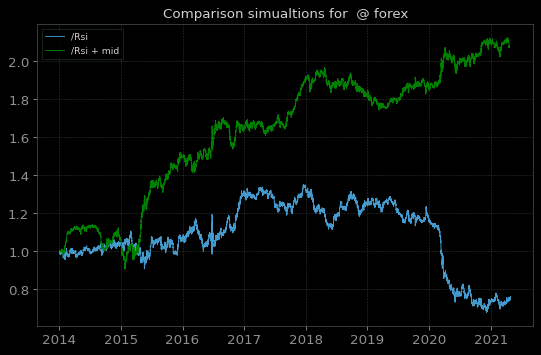

In [13]:
rc1.report(1)

In [14]:
portfolio = rc1.results[1].get_portfolio()


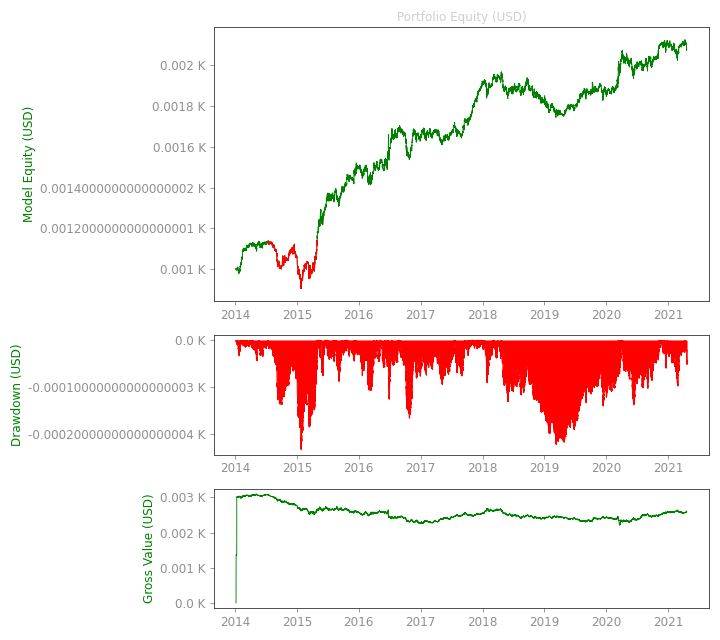

<Figure size 720x640 with 0 Axes>

In [15]:
tearsheet(portfolio, 1)

<hr/>
<h3>Best Parameters search</h3>
<hr/>

In [16]:
dEUR = {'EURUSD': ohlc_resample(data, '1h')['EURUSD']}

In [ ]:
s2 = q.make_pipeline(MidBarCalculator('1h'), RsiAndMiddle(16, 20, 80))

best = q.gridsearch('my exp', s2, q.ReverseSignalsSharpeScoring(commissions='dukas'), 
                    ohlc_resample(data, '1h'), 
#                     dEUR,  
                    q.permutate_params({
                     'midbarcalculator__timeframe': ['1h', '2h', '3h'],
                     'rsiandmiddle__low': [10, 15, 20],
                     'rsiandmiddle__period': urange(15,16,1),
                     'rsiandmiddle__up': [90, 85, 80] 
                    }, lambda rsiandmiddle__low, rsiandmiddle__up: rsiandmiddle__low + rsiandmiddle__up == 100)
            )

In [ ]:
best.predict(dEUR)

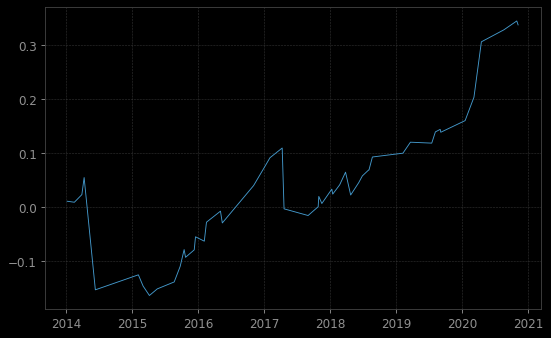

In [19]:
plt.plot(best.estimated_portfolio(dEUR, q.ReverseSignalsSharpeScoring(commissions='dukas')).cumsum())

In [20]:
best.best_params_

{'EURUSD': {'midbarcalculator__timeframe': '3h',
  'rsiandmiddle__low': 15,
  'rsiandmiddle__period': 16,
  'rsiandmiddle__up': 85}}

In [21]:
best.best_score_

{'EURUSD': 0.663710980505113}

In [22]:
t0 = q.simulation({
    'Reverse tests': [best, q.FixedTrader(10000, 0, 0)],
#     'Reverse ATR':   [best, q.ATRTracker(10000, '1h', 24, 5, 3)]
}, dEUR, 'forex', spreads=0)

 0: /Reverse tests  : Sharpe: -inf | Sortino: -0.69 | CAGR: -57.25 | DD: $1378.55 (80.86%) | Gain: $3297.60 | Execs: 51[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,/Reverse tests,-inf,-0.694909,-57.251706,1378.55,80.855744,3297.6,51


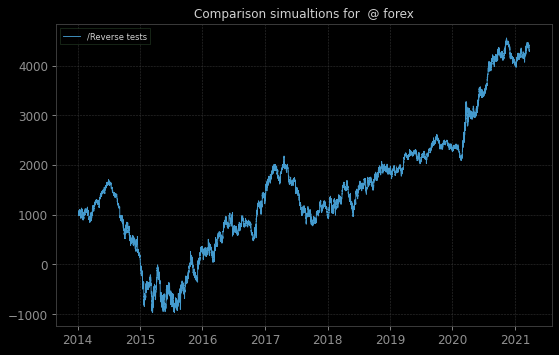

In [23]:
t0.report(1000)

<hr/>
<h3>Multi instrument strategy (portfolio)</h3>
<hr/>

In [32]:
import seaborn as sns

In [33]:
sxl = FriendlyFxLoader('nyse @ daily')
md = sxl.ohlcs(sxl.symbols())

In [34]:
@q.signal_generator
class PairsTrader(BaseEstimator):
    def __init__(self, period, z_period, pctls=5, nstd=None):
        self.period = period
        self.z_period = z_period
        self.pctls = pctls
        self.nstd = nstd
        
    def calc_z(self, x, y):
        s = x - y
        m = apply_to_frame(sma, s, self.period)
        ds = s - apply_to_frame(sma, s, self.period)
        return ds / ds.rolling(window=self.z_period, min_periods=self.z_period).std()

    def fit(self, X, y, **fit_params):
        s1, s2, *_ = self.market_info_.symbols
        closes = X.xs('close', axis=1, level=1)
        zs = self.calc_z(closes[s1], closes[s2])
        if self.nstd is None:
            self.zb_, self.zt_ = np.percentile(zs.dropna(), sorted([self.pctls, 100-self.pctls]))
        else:
            self.zb_, self.zt_ = self.nstd, -self.nstd
        print(self.zb_, self.zt_)
        
        return self

    def predict(self, X):
        s1, s2, *_ = self.market_info_.symbols
        closes = X.xs('close', axis=1, level=1)
        
        zs = self.calc_z(closes[s1], closes[s2])
        s_entries = q.crossdown(zs, self.zt_)
        l_entries = q.crossup(zs, self.zb_)
        
        short_spread = pd.DataFrame({s1: -1, s2: +1 }, s_entries)
        short_ex = None #pd.DataFrame({s1: 0, s2: 0 }, crossdown(zs, 0.5))
        
        long_spread = pd.DataFrame({s1: +1, s2: -1 }, l_entries)
        long_ex = None #pd.DataFrame({s1: 0, s2: 0 }, crossup(zs, -0.5))
        
        plt.plot(zs); plt.plot(zs.loc[s_entries], 'r.', ms=4);  plt.plot(zs.loc[l_entries], 'g.', ms=4)
        plt.axhline(self.zt_); plt.axhline(self.zb_)
        
        return srows(long_spread, long_ex, short_spread, short_ex).sort_index()

In [35]:
p_trader = PairsTrader(5, 20, 5)

fm = q.MarketDataComposer(p_trader, q.PortfolioPicker(['DHI$', 'PHM$']).for_range('2006'), None, 'close').fit(md, pd.Series(0))


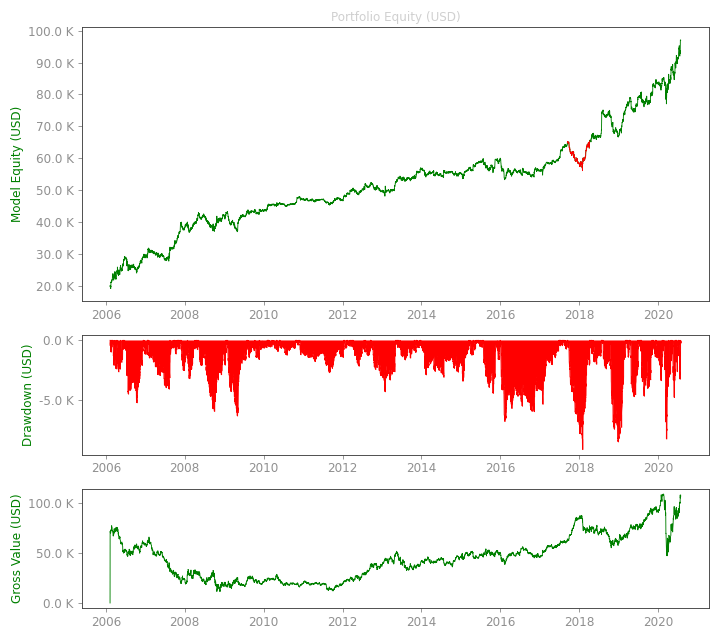

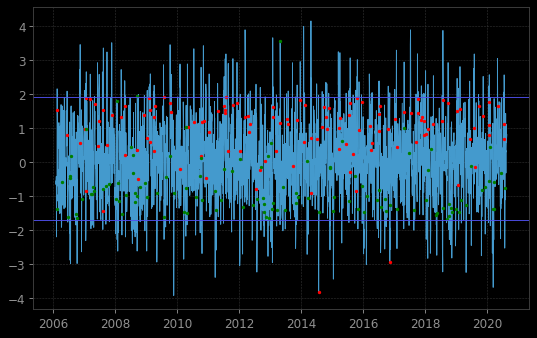

<Figure size 720x640 with 0 Axes>

In [36]:
p0 = z_test_signals_inplace(1000*fm.predict(md), md, 'stock', spread=0.1, verbose=False)
tearsheet(p0, 20000)

 > Selected [None:None]



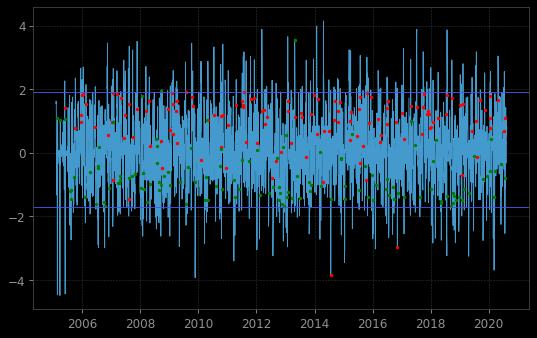

In [37]:
p0 = q.simulation(
    {'test1': [fm, q.FixedTrader(10, 0, 0)]}, md, 'stock', spreads=0.1)

 0: /test1  : Sharpe: 0.37 | Sortino: 0.85 | CAGR: 4.62 | DD: $392.05 (31.62%) | Gain: $1747.50 | Execs: 250[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,/test1,0.374594,0.849823,4.622725,392.05,31.620761,1747.5,250


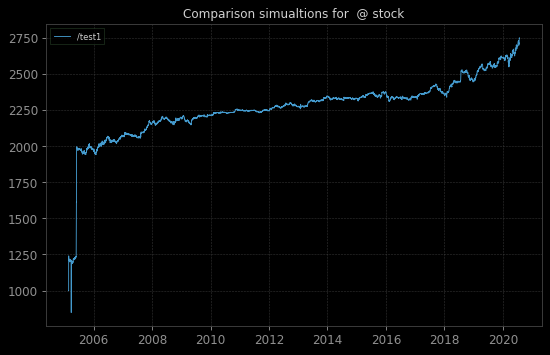

In [38]:
p0.report(1000)


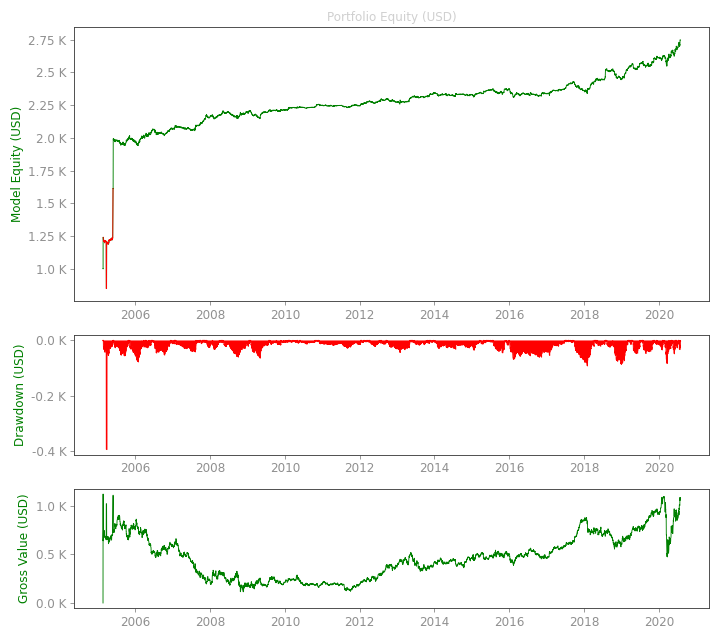

<Figure size 720x640 with 0 Axes>

In [134]:
tearsheet(p0.results[0].get_portfolio(commissions=2.5*100), 1000)

In [39]:
p0.results[0].executions

,instrument,quantity,exec_price,comment
2005-02-22,DHI,10,42.35,
2005-02-22,PHM,-10,69.48,
2005-05-26,DHI,-20,33.08,
2005-05-26,PHM,20,36.65,
2005-05-31,DHI,20,34.63,
...,...,...,...,...
2020-06-05,PHM,-20,34.96,
2020-07-10,DHI,-20,57.99,
2020-07-10,PHM,20,33.93,
2020-07-27,DHI,20,63.80,
